In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
# import fastcluster
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import math
from sklearn.decomposition import PCA
import scipy

In [2]:
history_close = pd.read_csv('history_close.csv')
history_close.set_index(['trade_date'],inplace=True)
history_close.index = history_close.index.astype('str')

history_ret = history_close.pct_change()
history_ret_3d = history_close.pct_change(periods=3)

history_ret_5d = history_close.pct_change(periods=5).iloc[5:]
history_ret_10d = history_close.pct_change(periods=10).iloc[10:]
history_ret_20d = history_close.pct_change(periods=20).iloc[20:]
history_ret_60d = history_close.pct_change(periods=60).iloc[60:]
history_ret_121d = history_close.pct_change(periods=121).iloc[121:]

In [ ]:
# 第一主成分、IH和510050的相关系数  stock对应ret右乘第一主成分
std_ret = (history_ret.iloc[:252,2:]-history_ret.iloc[:252,2:].mean())/history_ret.iloc[:252,2:].std() # 标准化ret
val, vec = np.linalg.eig(std_ret.corr())    # 相关系数矩阵的特征值 特征向量
first_eigenvecs = vec[:, val.argsort()[::-1]][:,0] 
fct = (history_ret.iloc[:252,2:]).dot(np.array(first_eigenvecs))
fct.name = 'stock'
train_ret = history_ret.iloc[:252][['510050','IH']].merge(fct,left_index=True, right_index=True)
from scipy.stats import spearmanr
corr, p = spearmanr(train_ret, axis=0)
print('train：')
print('秩相关系数：')
print(pd.DataFrame(corr,index=['510050','IH','stock'],columns=['510050','IH','stock']))
print('相关系数：')
print(train_ret.corr())

In [ ]:
# 第一主成分、IH和510050的loss
train_loss = pd.DataFrame(np.zeros([252,3]), index=history_ret.index[:252], columns=['510050','IH','stock'])
test_loss = pd.DataFrame(np.zeros([252,3]), index=history_ret.index[252:504], columns=['510050','IH','stock'])
train_ret = (train_ret - train_ret.mean())/train_ret.std()

# train_loss
OLSmodels_510050 = {stock: sm.OLS(history_ret.iloc[:252][stock], train_ret['510050']).fit() for stock in history_ret.columns[2:]} 
beta_510050 = pd.DataFrame({stock: model.params for stock, model in OLSmodels_510050.items()})
resids_510050 = pd.DataFrame({stock: model.resid for stock, model in OLSmodels_510050.items()})
train_loss['510050'] = resids_510050.apply(np.square).apply(np.sum,axis=1)

OLSmodels_IH = {stock: sm.OLS(history_ret.iloc[:252][stock], train_ret['IH']).fit() for stock in history_ret.columns[2:]} 
beta_IH = pd.DataFrame({stock: model.params for stock, model in OLSmodels_IH.items()})
resids_IH = pd.DataFrame({stock: model.resid for stock, model in OLSmodels_IH.items()})
train_loss['IH'] = resids_IH.apply(np.square).apply(np.sum,axis=1)

OLSmodels_stock = {stock: sm.OLS(history_ret.iloc[:252][stock], train_ret['stock']).fit() for stock in history_ret.columns[2:]} 
beta_stock = pd.DataFrame({stock: model.params for stock, model in OLSmodels_stock.items()})
resids_stock = pd.DataFrame({stock: model.resid for stock, model in OLSmodels_stock.items()})
train_loss['stock'] = resids_stock.apply(np.square).apply(np.sum,axis=1)

# test_loss
for i in range(252): # 接下来的252天
    cur_returns = history_ret.iloc[252+i,2:]
    out_resids_510050 = cur_returns - cur_returns.dot(np.array(first_eigenvecs)) * beta_510050
    test_loss.iloc[i]['510050'] = sum(i**2 for i in out_resids_510050.iloc[0])

    out_resids_IH = cur_returns - cur_returns.dot(np.array(first_eigenvecs)) * beta_IH
    test_loss.iloc[i]['IH'] = sum(i**2 for i in out_resids_IH.iloc[0])

    out_resids_stock = cur_returns - cur_returns.dot(np.array(first_eigenvecs)) * beta_stock
    test_loss.iloc[i]['stock'] = sum(i**2 for i in out_resids_stock.iloc[0])

In [ ]:
train_loss.describe()

In [ ]:
test_loss.describe()

In [ ]:
# 不同n_component下的loss
def train_test(history_ret):
    sum_square_loss = pd.DataFrame(np.zeros([50,2]),index=np.arange(1,51), columns=['train','test'])
    median_abs_loss = pd.DataFrame(np.zeros([50,2]),index=np.arange(1,51), columns=['train','test'])
    std_ret = (history_ret.iloc[:252,2:]-history_ret.iloc[:252,2:].mean())/history_ret.iloc[:252,2:].std() # 标准化ret
    val, vec = np.linalg.eig(std_ret.corr())    # 相关系数矩阵的特征值 特征向量
    all_eigenvecs = vec[:, val.argsort()[::-1]]

    for n_component in range(1,51):
        # out_fct和beta为outofsample测试要用的参数 还包括original_returns.std()
        eigenvecs = all_eigenvecs[:, :n_component]
        fct = history_ret.iloc[:252,2:].dot(np.array(eigenvecs)) # 保存factor
        OLSmodels = {stock: sm.OLS(history_ret.iloc[:252][stock], fct).fit() for stock in history_ret.columns[2:]} # ret与factor做回归
        beta = pd.DataFrame({stock: model.params for stock, model in OLSmodels.items()}) # 保存回归系数beta 
        # train_loss     
        resids = pd.DataFrame({stock: model.resid for stock, model in OLSmodels.items()})
        sum_square_loss.loc[n_component]['train'] = resids.apply(np.square).apply(np.sum,axis=1).sum()
        median_abs_loss.loc[n_component]['train'] = resids.apply(np.abs).apply(np.median,axis=1).sum()
        # test_loss
        for i in range(252): # 接下来的252天
            cur_returns = history_ret.iloc[252+i, 2:]
            out_resids = cur_returns - cur_returns.dot(np.array(eigenvecs)).dot(beta)
            sum_square_loss.loc[n_component]['test'] += sum(i**2 for i in out_resids)
            median_abs_loss.loc[n_component]['test'] += np.median(np.abs(out_resids.to_list()))
    sum_square_loss = sum_square_loss / 252 # 对残差平方和求均值
    sum_square_loss.plot()
    plt.xlabel('n_component')
    plt.ylabel('sum of loss squares')
    plt.show()
    median_abs_loss = median_abs_loss / 252
    median_abs_loss.plot()
    plt.xlabel('n_component')
    plt.ylabel('median of loss abs')
    plt.show()

In [ ]:
train_test(history_ret)

In [22]:
def cal_res(component,window):  
    cur_ret_P = []
    cur_ret__ = []
    cum_ret_P = [0]
    cum_ret__ = [0]
    res = pd.DataFrame(np.zeros([len(history_ret.index[window:-3]),len(history_ret.columns)]), index=history_ret.index[window:-3],columns=history_ret.columns)

    for cur_num in range(window+1, history_ret.shape[0]-2):
        original_returns = history_ret.iloc[cur_num-window:cur_num,2:]
        cur_returns = original_returns.iloc[-1]
        returns = (original_returns - original_returns.mean())/original_returns.std()
        eigenvals_P, eigenvecs_P = np.linalg.eig(returns.corr())
        idx_P = eigenvals_P.argsort()[::-1]  
        eigenvecs_P = np.real(eigenvecs_P) 
        pca_eigenvecs = eigenvecs_P[:, idx_P][:, :component]  
        fct_P = np.dot(original_returns,pca_eigenvecs)
        OLSmodels_P = {stock: sm.OLS(original_returns[stock], fct_P).fit() for stock in original_returns.columns}
        beta_P = pd.DataFrame({stock: model_P.params for stock, model_P in OLSmodels_P.items()})
        cur_res = cur_returns - cur_returns.dot(np.array(pca_eigenvecs)).dot(beta_P)
        res.loc[history_ret.index[cur_num-1]] += cur_res
        long_P = cur_res[cur_res < 0]
        short_P = cur_res[cur_res > 0]

        # PCA选股
        if len(long_P) != 0:
            weights_long_P =  long_P * (1 / long_P.sum())
        else: weights_long_P = long_P
        if len(short_P) != 0:
            weights_short_P =  short_P * (1 / short_P.sum())
        else: weights_short_P = short_P
        cur_ret_P.append(((sum(weights_long_P*history_ret_3d[weights_long_P.index].iloc[cur_num+2]) - sum(weights_short_P*history_ret_3d[weights_short_P.index].iloc[cur_num+2]))/2 - history_ret_3d.iloc[cur_num+2,0]))
        cum_ret_P.append((1+cum_ret_P[-1])*(1+cur_ret_P[-1])-1)
        cur_ret__.append(history_ret_3d.iloc[cur_num+2,0])
        cum_ret__.append((1+cum_ret__[-1])*(1+cur_ret__[-1])-1)

    # cum画图
    df_cum = pd.DataFrame(np.array([cum_ret_P,cum_ret__]).T, columns=['PCA alpha','beta'], index=history_close.index[window+2:])
    df_cum.plot()
    plt.title('cum_{}_{}'.format(component,window))
    plt.xticks(rotation=30, fontsize=8)
    plt.savefig('d:/res_data/cum_{}_{}.png'.format(component,window))
    plt.show()
    # 保存数据
    df_cum.to_csv('d:/res_data/cum_{}_{}.csv'.format(component,window))
    res.iloc[:,2:].to_csv('d:/res_data/res_{}_{}.csv'.format(component,window))

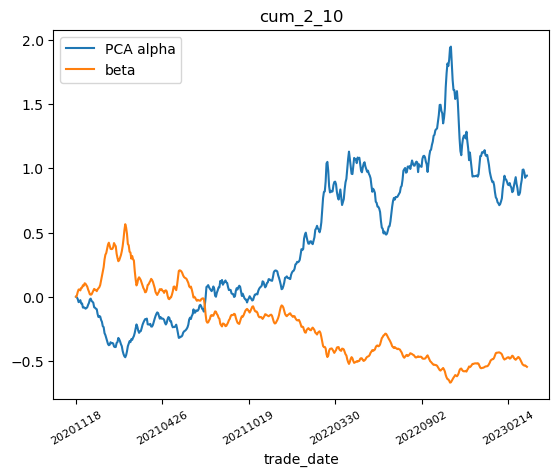

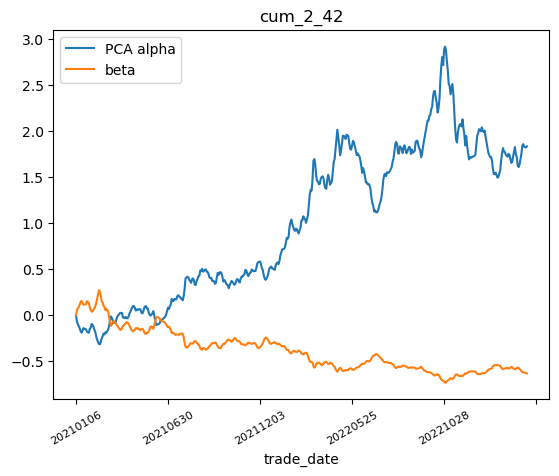

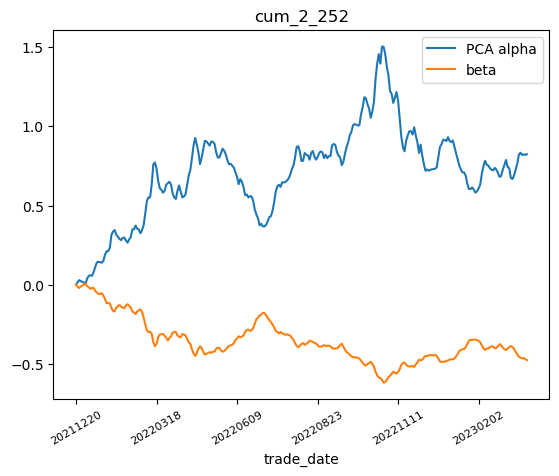

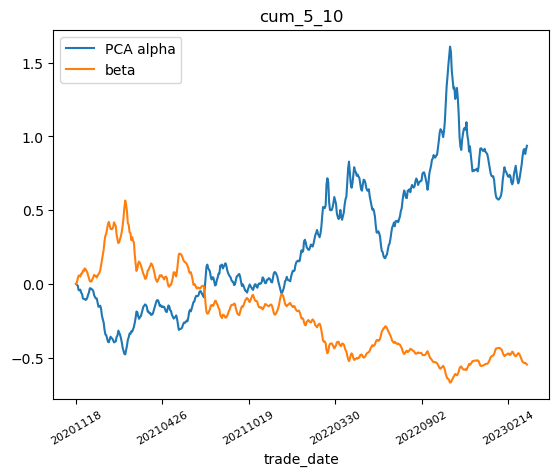

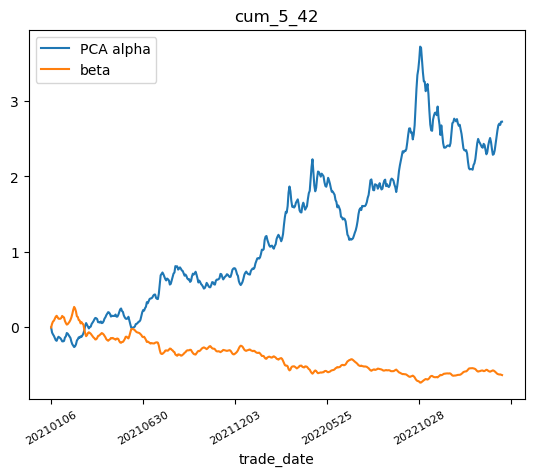

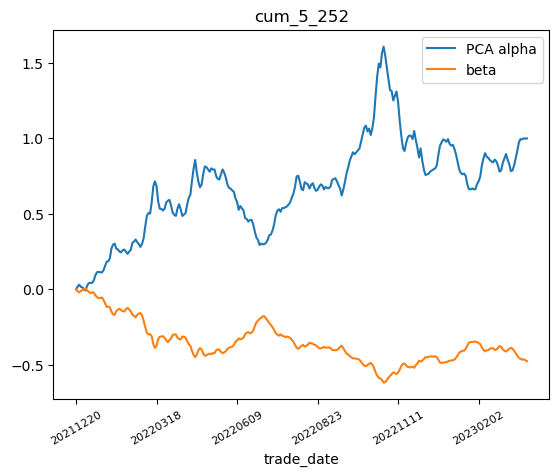

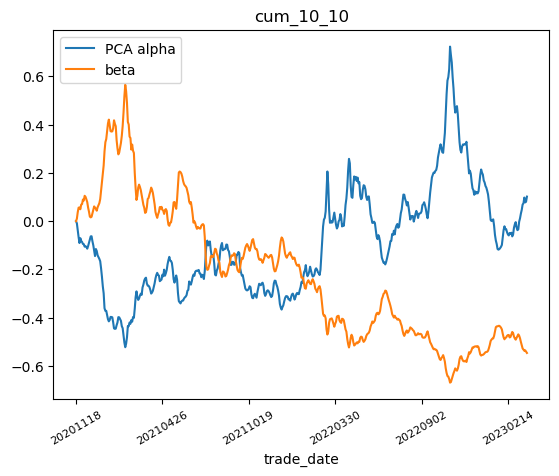

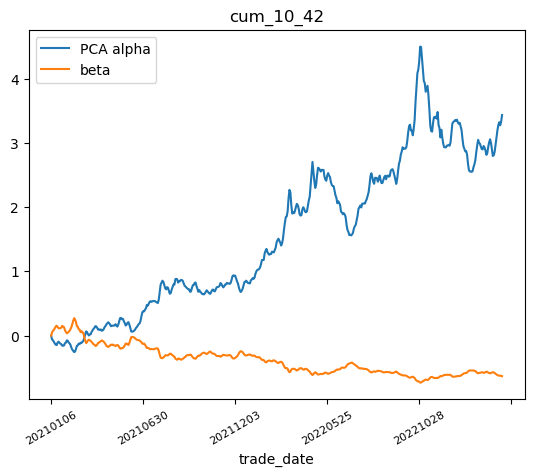

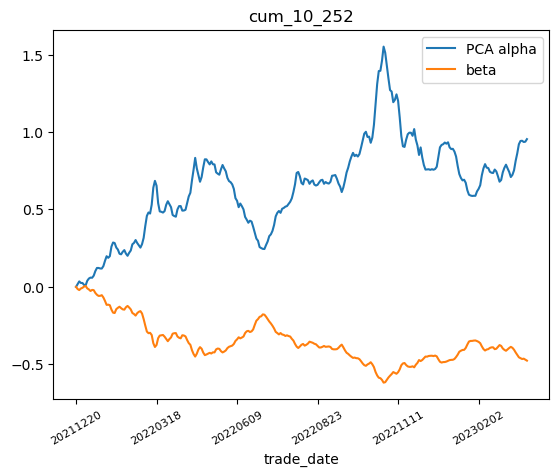

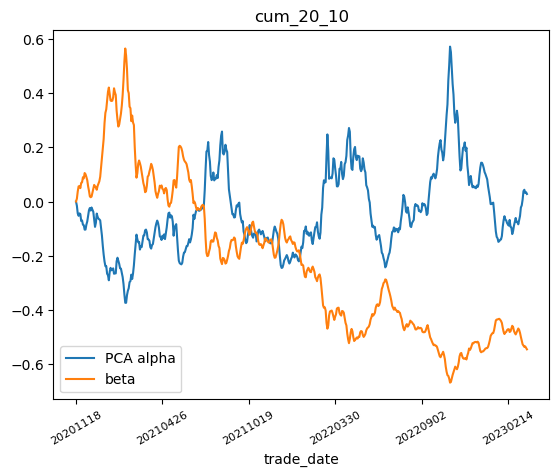

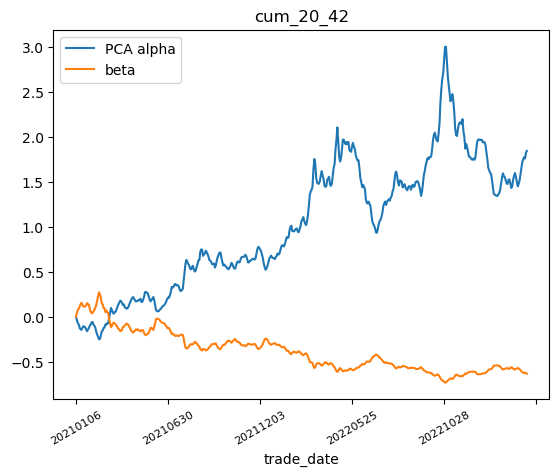

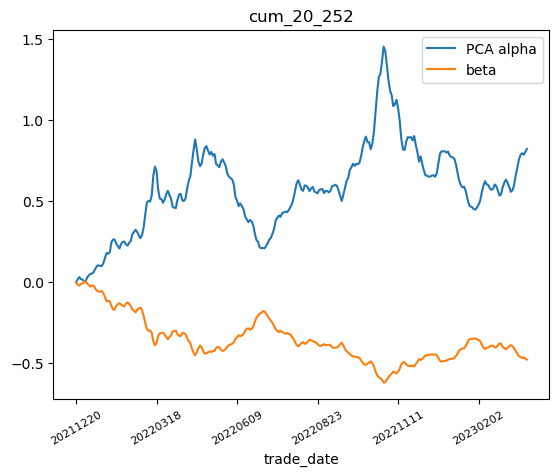

In [23]:
for component in [2,5,10,20]:
    for window in [10,42,252]:
        cal_res(component,window)

In [23]:
#数据处理 准备标签
import pathlib
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')
folder = pathlib.Path.cwd().parent.joinpath('D:/res_data/res')#文件夹路径

predata = {}
data = {}
for fp in folder.iterdir():#迭代文件夹
    varname = fp.parts[-1].split('.')[0]#按照‘.’的方式切割，取-1，得到csv文件的名字
    predata[varname] = pd.read_csv(fp)#添加文件，转为pandas的DataFrame
label = pd.DataFrame(history_ret_3d.iloc[3:,2:])
label.index = history_ret_3d.index[:-3]
label[label>0] = 1
label[label<0] = -1
stocks = label.columns
predata['label'] = label

for stock in stocks:
    data[stock] = pd.DataFrame()
    for key, value in predata.items():
        data[stock][key] = value[stock]

In [27]:
for stock,value in data.items():
    a = data[stock]
a

,res_10_10,res_10_252,res_10_42,res_20_10,res_20_252,res_20_42,res_2_10,res_2_252,res_2_42,res_5_10,res_5_252,res_5_42,label
0,-1.110223e-16,0.006425,0.019485,-1.387779e-17,0.009090,-0.007330,-0.013813,0.002774,-0.010111,-0.013873,0.004508,0.003718,NaN
1,-2.498002e-16,-0.003374,-0.001328,-2.775558e-17,-0.014754,-0.010445,0.082761,0.000359,0.027331,0.050815,0.007844,0.017884,NaN
2,-2.081668e-17,0.000774,-0.009405,4.510281e-17,-0.000226,-0.005773,0.008412,-0.009055,-0.021520,-0.018160,0.005572,-0.005526,NaN
3,6.938894e-18,0.005221,0.007398,5.898060e-17,-0.004681,0.007664,-0.044218,0.015627,-0.032682,0.008019,0.011214,0.003095,NaN
4,3.642919e-17,-0.006452,-0.002520,-1.734723e-18,-0.005261,-0.001159,0.012536,0.025939,0.016721,0.004963,0.008751,0.010111,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,2.255141e-17,NaN,NaN,2.602085e-18,NaN,NaN,0.002921,NaN,NaN,-0.001360,NaN,NaN,NaN
518,-1.474515e-17,NaN,NaN,-6.505213e-18,NaN,NaN,0.007675,NaN,NaN,0.005124,NaN,NaN,NaN
519,8.673617e-18,NaN,NaN,2.775558e-17,NaN,NaN,-0.003202,NaN,NaN,-0.002933,NaN,NaN,NaN
520,-1.994932e-17,NaN,NaN,-3.382711e-17,NaN,NaN,0.005155,NaN,NaN,-0.000873,NaN,NaN,NaN


In [ ]:
# ETF和股指的ret分布
def normfun(x, mu, sigma):
     pdf = np.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) / (sigma * np.sqrt(2 * np.pi))
     return pdf
IH = pd.read_csv('IH.csv')
IH.set_index(['dateStr'],inplace=True)
_510050 = pd.read_csv('510050.csv')
_510050.set_index(['dateStr'],inplace=True)
l = list(set(IH.index).intersection(set(_510050.index)))
IH = IH.loc[l]
_510050 = _510050.loc[l]
x = np.arange(-0.3, 0.4, 0.001)
# 设定Y轴，载入刚才定义的正态分布函数
y = normfun(x, IH['lp'].pct_change().iloc[1:].mean(), IH['lp'].pct_change().iloc[1:].std())
# 绘制数据集的正态分布曲线
plt.plot(x, y)

plt.hist(IH['lp'].pct_change().iloc[1:],bins=50,density=True)
plt.show()

In [ ]:
index = pd.read_excel('index.xlsx')
index = index.drop('Open',axis=1)
index.set_index(['Date'],inplace=True)
ret = index.pct_change().iloc[1:]
ret = (ret - ret.mean()) / ret.std()
x = np.arange(-6, 6, 0.001)

for i in index.columns:
    ret_ = ret[i]
    y = normfun(x, ret_.mean(), ret_.std())
    plt.plot(x, y)
    plt.hist(ret_,bins=100,density=True)
    plt.title(i)
    plt.show()
    print(scipy.stats.kstest(ret_,'norm',(ret_.mean(), ret_.std())))

In [ ]:
# 测试相关性
date = []
window_length = 200

n_component = 50
# 获取标准化实验数据
# original_returns = history_ret.iloc[:window_length,2:]
# returns = (original_returns - original_returns.mean())/original_returns.std()

# eigenvals_P, eigenvecs_P = np.linalg.eig(returns.corr())
# idx_P = eigenvals_P.argsort()[::-1]   
# pca_eigenvecs = eigenvecs_P[:, idx_P][:, :n_component]  
# fct_P = np.dot(original_returns,pca_eigenvecs)
# OLSmodels_P = {stock: sm.OLS(original_returns[stock], fct_P).fit() for stock in original_returns.columns}
# beta_P = pd.DataFrame({stock: model_P.params for stock, model_P in OLSmodels_P.items()})
# res = pd.DataFrame(index=history_ret.index[window_length:-1],columns=original_returns.columns)
spm = pd.DataFrame(index=history_ret.index,columns=['1d','3d','5d','10d','20d','121d'])

for cur_num in range(window_length, history_ret.shape[0]-122):
    date.append(history_ret.index[cur_num-1])
    print('date:', date[-1])
    # cur_returns = history_ret.iloc[cur_num,2:]
    # cur_res = cur_returns - cur_returns.dot(np.array(pca_eigenvecs)).dot(beta_P)
    # res.loc[date] += cur_res
    original_returns = history_ret.iloc[cur_num-window_length:cur_num,2:]
    cur_returns = original_returns.iloc[-1]
    returns = (original_returns - original_returns.mean())/original_returns.std()
    eigenvals_P, eigenvecs_P = np.linalg.eig(returns.corr())
    idx_P = eigenvals_P.argsort()[::-1]   
    pca_eigenvecs = eigenvecs_P[:, idx_P][:, :n_component]  
    fct_P = np.dot(original_returns,pca_eigenvecs)
    OLSmodels_P = {stock: sm.OLS(original_returns[stock], fct_P).fit() for stock in original_returns.columns}
    beta_P = pd.DataFrame({stock: model_P.params for stock, model_P in OLSmodels_P.items()})
    cur_res = cur_returns - cur_returns.dot(np.array(pca_eigenvecs)).dot(beta_P)
    # spm.loc[date[-1]]['1d'] = cur_res.corr(history_ret.iloc[cur_num,2:])
    # spm.loc[date[-1]]['3d'] = cur_res.corr(history_ret_3d.iloc[cur_num,2:])
    # spm.loc[date[-1]]['5d'] = cur_res.corr(history_ret_5d.iloc[cur_num,2:])
    # spm.loc[date[-1]]['10d'] = cur_res.corr(history_ret_10d.iloc[cur_num,2:])
    # spm.loc[date[-1]]['20d'] = cur_res.corr(history_ret_20d.iloc[cur_num,2:])
    spm.loc[date[-1]]['121d'] = cur_res.corr(history_ret_121d.iloc[cur_num,2:])
# for cur_num in range(window_length, history_ret.shape[0]-30):
#     date.append(history_ret.index[cur_num])
#     print('date:', date[-1])
#     cur_returns = history_ret.iloc[cur_num,2:]
#     cur_res = cur_returns - cur_returns.dot(np.array(pca_eigenvecs)).dot(beta_P)
#     res.loc[date[-1]] = cur_res
#     spm.loc[date[-1]]['1d'] = cur_res.corr(history_ret.iloc[cur_num+1,2:])
#     spm.loc[date[-1]]['3d'] = cur_res.corr(history_ret_3d.iloc[cur_num+1,2:])
#     spm.loc[date[-1]]['5d'] = cur_res.corr(history_ret_5d.iloc[cur_num+1,2:])
#     spm.loc[date[-1]]['10d'] = cur_res.corr(history_ret_10d.iloc[cur_num+1,2:])
#     spm.loc[date[-1]]['20d'] = cur_res.corr(history_ret_20d.iloc[cur_num+1,2:])
#     spm.loc[date[-1]]['121d'] = cur_res.corr(history_ret_20d.iloc[cur_num+1,2:])
spm.dropna()

In [ ]:
spm.astype('float64').describe()

In [ ]:
spm.plot()
plt.title('spearman between residuals and returns')
plt.show()

In [ ]:
spx = pd.read_excel('spx_.xls')
spx.set_index([spx.columns[2]], inplace=True)
spx = spx['涨跌幅%'].iloc[1:].astype('float64').rename('spx')/100
index_ret = index['HS'].pct_change().iloc[1:]
zz_ret = index['ZZ'].pct_change().iloc[1:]
data = pd.merge(spx, index_ret, how='inner', left_index=True, right_index=True)
data = pd.merge(data, zz_ret, how='inner', left_index=True, right_index=True)
data = data[:3068]
ret = pd.DataFrame(np.zeros([13,6]), index=np.arange(1,14), columns=['spx','spx*','hs300','hs300*','zz1000','zz1000*'])
minus = pd.DataFrame(np.zeros([13,3]), index=np.arange(1,14), columns=['spx','hs300','zz1000'])

In [ ]:
for day in [3,5,10]:
    for i in range(13):
        l_spx = data.iloc[i*236:(i+1)*236]['spx']
        l_hs = data.iloc[i*236:(i+1)*236]['HS']
        l_zz = data.iloc[i*236:(i+1)*236]['ZZ']
        ret.iloc[i]['spx'] = l_spx.std()
        ret.iloc[i]['spx*'] = l_spx.sort_values()[:-day].std()
        ret.iloc[i]['hs300'] = l_hs.std()
        ret.iloc[i]['hs300*'] = l_hs.sort_values()[:-day].std()        
        ret.iloc[i]['zz1000'] = l_zz.std()
        ret.iloc[i]['zz1000*'] = l_zz.sort_values()[:-day].std()
    ret = ret*100
    ret.plot.bar()
    plt.title('drop {} days'.format(day))
    plt.show()
    minus['spx'] = ret['spx'] - ret['spx*']
    minus['hs300'] = ret['hs300'] - ret['hs300*']
    minus['zz1000'] = ret['zz1000'] - ret['zz1000*']
    minus.plot.bar()
    plt.title('drop {} days'.format(day))
    plt.show()    


In [ ]:
spx.index